In [72]:
import pandas as pd
from pandasql import sqldf
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier as xgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt

## Loading Data

In [16]:
df=pd.read_csv("diabetes_data_clean.csv")
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,Diabetes
0,4,1,0,1,26,0,1,0,1,0,3,0
1,12,1,1,1,26,1,0,1,0,0,3,0
2,13,1,0,1,26,0,1,1,1,0,1,0
3,11,1,1,1,28,1,1,1,1,0,3,0
4,8,0,0,1,29,1,1,1,1,0,2,0


## Engineer Features

In [17]:
#Convert categorical variable into numeric
df=sqldf("""
select*,
case when BMI <=15 then 0
     when BMI <=20 then 1
     when BMI<=25 then 2
     when BMI<=30 then 3
     else 4
     end as BMI_Num
from df
""")

df.columns = df.columns.str.lower()
df

,age,sex,highchol,cholcheck,bmi,smoker,physactivity,fruits,veggies,hvyalcoholconsump,genhlth,diabetes,bmi_num
0,4,1,0,1,26,0,1,0,1,0,3,0,3
1,12,1,1,1,26,1,0,1,0,0,3,0,3
2,13,1,0,1,26,0,1,1,1,0,1,0,3
3,11,1,1,1,28,1,1,1,1,0,3,0,3
4,8,0,0,1,29,1,1,1,1,0,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,6,0,1,1,37,0,0,0,1,0,4,1,4
70688,10,1,1,1,29,1,0,1,1,0,2,1,3
70689,13,0,1,1,25,0,0,1,0,0,5,1,2
70690,11,0,1,1,18,0,0,0,0,0,4,1,1


In [127]:
df['diabetes'].unique()

array([0, 1], dtype=int64)

In [166]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(["diabetes","bmi","cholcheck","sex","highchol"],axis=1),df['diabetes'],
                                                    test_size=0.2,random_state=2022)

print(x_train.shape)
print(x_test.shape)

(56553, 8)
(14139, 8)


In [189]:
#model=RandomForestClassifier(max_depth=5, n_estimators=100, min_samples_split=2,max_leaf_nodes=5)
model=xgb(learning_rate=0.1,n_estimators=1000,max_depth=6,gamma=1,seed=1234, use_label_encoder=False)
#model = LogisticRegression(penalty='none')
model.fit(x_train,y_train)

[16:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=1234,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [190]:
#ROC / AUC
insample_pred=model.predict_proba(x_train)[:,1]
oot_pred=model.predict_proba(x_test)[:,1]

roc_score_insample=metrics.roc_auc_score(y_train,insample_pred)
roc_score_oot=metrics.roc_auc_score(y_test,oot_pred)

print("AR for In Sample is: ",2*roc_score_insample-1)
print("AR for OOT is: ",2*roc_score_oot-1)

AR for In Sample is:  0.623973031494736
AR for OOT is:  0.6023067985990596


In [22]:
#Roc Curve
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_train,insample_pred)
fpr_v, tpr_v, thresholds_v = metrics.roc_curve(y_test,oot_pred)

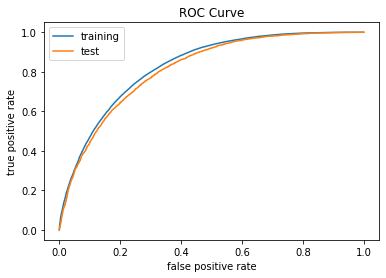

In [23]:
plt.plot(fpr_t,tpr_t, label='training')
plt.plot(fpr_v, tpr_v,label='test')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Save as pickle file

In [233]:
import pickle

filename = 'xgb_diabetes_model_v2.sav'
pickle.dump(model, open(filename, 'wb'))

## Analysing score band

In [90]:
#y_train,insample_pred
df_score=pd.DataFrame()
df_score['survived']=y_train
df_score['pred_probability']=insample_pred

<AxesSubplot:ylabel='Frequency'>

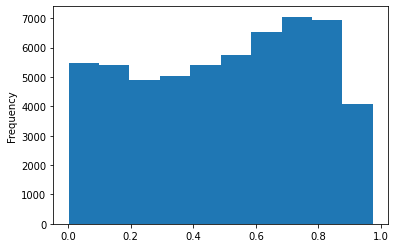

In [91]:
df_score['pred_probability'].plot.hist("pred_probability")

In [12]:
df_score=sqldf("""
select*,
case when pred_probability<=0.13 then 5
     when pred_probability>0.13 and pred_probability<=0.30 then 4
     when pred_probability>0.30 and pred_probability<=0.48 then 3
     when pred_probability>0.48 and pred_probability<=0.91 then 2
     else 1
     end as score_band
from df_score  
     
     
""")

In [13]:
sqldf("""
select score_band,
sum(survived) as total_survived,
count(survived) as total_passengers,
max(pred_probability) as max_prob,
min(pred_probability) as min_prob,
sum(survived)*1.0/count(survived) as survival_rate
from df_score
group by score_band

""")

,score_band,total_survived,total_passengers,max_prob,min_prob,survival_rate
0,1,86,88,0.939840,0.910645,0.977273
1,2,92,127,0.902520,0.500912,0.724409
2,3,62,166,0.459341,0.336412,0.373494
3,4,33,269,0.156164,0.130066,0.122677
4,5,4,62,0.123959,0.115018,0.064516


## Function to manage prediction pipeline

In [24]:
df.columns

Index(['age', 'sex', 'highchol', 'cholcheck', 'bmi', 'smoker', 'physactivity',
       'fruits', 'veggies', 'hvyalcoholconsump', 'genhlth', 'diabetes',
       'bmi_num'],
      dtype='object')

In [201]:
def diabetes_pipe(in_age, in_bmi, in_smoker, in_physactivity,
                  in_fruits, in_veggies, in_hvyalcoholconsump, in_genhlth):
    
    if in_age<=24:
        age=1
    elif in_age<=29:
        age=2
    elif in_age<=34:
        age=3
    elif in_age<=39:
        age=4
    elif in_age<=44:
        age=5
    elif in_age<=49:
        age=6
    elif in_age<=54:
        age=7
    elif in_age<=59:
        age=8
    elif in_age<=64:
        age=9
    elif in_age<=79:
        age=10
    elif in_age<=74:
        age=11
    elif in_age<=79:
        age=12
    else:
        age=13
        
    if in_bmi<=15:
        bmi=0
    elif in_bmi<=20:
        bmi=1
    elif in_bmi<=25:
        bmi=2
    elif in_bmi<=30:
        bmi=3
    else:
        bmi=4
        
    if in_sex=='Female':
        sex=0
    else:
        sex=1
        
    if in_highchol=='Yes':
        highchol=1
    else:
        highchol=0
        
    if in_cholcheck=='Yes':
        cholcheck=1
    else:
        cholcheck=0
    
    if in_smoker=='Yes':
        smoker=1
    else:
        smoker=0
     
    if in_physactivity=='Yes':
        physactivity=1
    else:
        physactivity=0

    if in_fruits=='Yes':
        fruits=1
    else:
        fruits=0

    if in_veggies=='Yes':
        veggies=1
    else:
        veggies=0
        
    if in_hvyalcoholconsump=='Yes':
        hvyalcoholconsump=1
    else:
        hvyalcoholconsump=0

    if in_genhlth=='Excellent':
        genhlth=1
    elif in_genhlth=='Good':
        genhlth=1
    elif in_genhlth=='Fair':
        genhlth=3
    elif in_genhlth=='Relatively Poor':
        genhlth=4
    else:
        genhlth=5

    return age, bmi, smoker, physactivity,fruits, veggies, hvyalcoholconsump, genhlth

def diabetes_pred(model_diabetes,age, bmi, smoker, physactivity,
                  fruits, veggies, hvyalcoholconsump, genhlth):
    df=pd.DataFrame()
    df['age']=[age]
    df['bmi']=[bmi]
    df['smoker']=[smoker]
    df['physactivity']=[physactivity]
    df['fruits']=[fruits]
    df['veggies']=[veggies]
    df['hvyalcoholconsump']=[hvyalcoholconsump]
    df['genhlth']=[genhlth]
    
    pred=model_diabetes.predict_proba(df)[:,1]
    
    if pred<=0.10:
        score=1
    elif pred<=0.20:
        score=2
    elif pred<=0.30:
        score=3
    elif pred<=0.50:
        score=4
    else:
        score=5
    
    return score, pred


In [297]:
#test
in_age=41
in_sex="Male"
in_highchol="Yes"
in_cholcheck="Yes"
in_bmi=35
in_smoker="Yes"
in_physactivity="No"
in_fruits="No"
in_veggies="No"
in_hvyalcoholconsump="Yes"
in_genhlth="Fair"

x1,x2,x3,x4,x5,x6,x7,x8=diabetes_pipe(in_age, in_bmi, in_smoker, in_physactivity,
                                                 in_fruits, in_veggies, in_hvyalcoholconsump, in_genhlth)
print(x1,x2,x3,x4,x5,x6,x7,x8)

5 4 1 0 0 0 1 3


In [298]:
diabetes_pred(model,x1,x2,x3,x4,x5,x6,x7,x8)

(1, array([0.05236724], dtype=float32))

In [188]:
model.coef_

array([[ 0.22551243,  0.06167334, -0.06789747, -0.07486275, -0.12768924,
        -0.7365845 ,  0.72377731,  0.70254159]])

## Test load back model

In [17]:
load_model = pickle.load(open(filename, 'rb'))

In [18]:
titanic_pred(load_model,x1,x2,x3,x4)[0]

2